STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

# Dropout

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import time

In [2]:
%matplotlib inline

## Settings and Dataset

In [3]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_HIDDEN_1 = 75
NUM_HIDDEN_2 = 65
DROP_PROBA = 0.5
NUM_EPOCHS = 35
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
train_indices = torch.arange(1000, 60000)
valid_indices = torch.arange(0, 1000)


train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


training_transform = transforms.Compose([#transforms.Resize((32, 32)),
                                         #transforms.RandomCrop((28, 28)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=(0.5,), std=(0.5,))])

valid_transform = transforms.Compose([#transforms.Resize((32, 32)),
                                      #   transforms.CenterCrop((28, 28)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(0.5,))])





train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=training_transform,
                               
                               download=True)

# note that this is the same dataset as "train_dataset" above
# however, we can now choose a different transform method
valid_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=valid_transform,
                               download=False)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=valid_transform,
                              download=False)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          drop_last=True,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          sampler=valid_sampler)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

In [5]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28)
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

## No Dropout

In [6]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes,
                 num_hidden_1, num_hidden_2):
        super(MultilayerPerceptron, self).__init__()
        
        self.my_network = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_2, num_classes)
        )
           
    def forward(self, x):
        logits = self.my_network(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [7]:
#################################
### Model Initialization
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#################################
### Training
#################################

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28)
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | ' 
                   f'Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/035 | Batch 000/230 | Cost: 2.3047
Epoch: 001/035 | Batch 120/230 | Cost: 0.4399
Epoch: 001/035 Train Acc.: 88.94% | Validation Acc.: 88.90%
Time elapsed: 0.10 min
Epoch: 002/035 | Batch 000/230 | Cost: 0.3447
Epoch: 002/035 | Batch 120/230 | Cost: 0.3083
Epoch: 002/035 Train Acc.: 92.61% | Validation Acc.: 92.40%
Time elapsed: 0.20 min
Epoch: 003/035 | Batch 000/230 | Cost: 0.2235
Epoch: 003/035 | Batch 120/230 | Cost: 0.2224
Epoch: 003/035 Train Acc.: 94.08% | Validation Acc.: 94.20%
Time elapsed: 0.30 min
Epoch: 004/035 | Batch 000/230 | Cost: 0.1564
Epoch: 004/035 | Batch 120/230 | Cost: 0.2258
Epoch: 004/035 Train Acc.: 94.35% | Validation Acc.: 93.60%
Time elapsed: 0.41 min
Epoch: 005/035 | Batch 000/230 | Cost: 0.1891
Epoch: 005/035 | Batch 120/230 | Cost: 0.2127
Epoch: 005/035 Train Acc.: 95.53% | Validation Acc.: 95.00%
Time elapsed: 0.51 min
Epoch: 006/035 | Batch 000/230 | Cost: 0.1217
Epoch: 006/035 | Batch 120/230 | Cost: 0.1448
Epoch: 006/035 Train Acc.: 96.21%

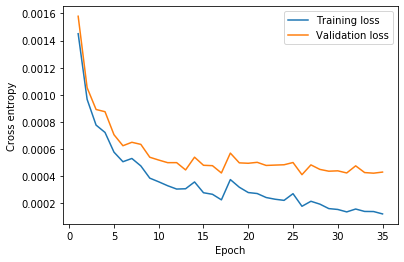

In [8]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [9]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 97.41%


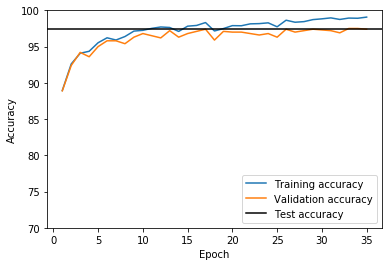

In [10]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.axhline(y=test_acc, c='black', label='Test accuracy')
plt.ylim([70, 100])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Object-Oriented Dropout

In [11]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes, drop_proba, 
                 num_hidden_1, num_hidden_2):
        super(MultilayerPerceptron, self).__init__()
        
        self.my_network = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            torch.nn.Linear(num_hidden_2, num_classes)
        )
           
    def forward(self, x):
        logits = self.my_network(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [12]:
#################################
### Model Initialization
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=DROP_PROBA,
                             num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#################################
### Training
#################################

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28)
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | ' 
                   f'Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/035 | Batch 000/230 | Cost: 2.3072
Epoch: 001/035 | Batch 120/230 | Cost: 0.9767
Epoch: 001/035 Train Acc.: 85.94% | Validation Acc.: 85.20%
Time elapsed: 0.11 min
Epoch: 002/035 | Batch 000/230 | Cost: 0.7529
Epoch: 002/035 | Batch 120/230 | Cost: 0.7045
Epoch: 002/035 Train Acc.: 89.54% | Validation Acc.: 88.80%
Time elapsed: 0.22 min
Epoch: 003/035 | Batch 000/230 | Cost: 0.6117
Epoch: 003/035 | Batch 120/230 | Cost: 0.5544
Epoch: 003/035 Train Acc.: 91.41% | Validation Acc.: 91.00%
Time elapsed: 0.33 min
Epoch: 004/035 | Batch 000/230 | Cost: 0.5756
Epoch: 004/035 | Batch 120/230 | Cost: 0.4749
Epoch: 004/035 Train Acc.: 92.28% | Validation Acc.: 92.30%
Time elapsed: 0.44 min
Epoch: 005/035 | Batch 000/230 | Cost: 0.4690
Epoch: 005/035 | Batch 120/230 | Cost: 0.4591
Epoch: 005/035 Train Acc.: 93.00% | Validation Acc.: 93.80%
Time elapsed: 0.55 min
Epoch: 006/035 | Batch 000/230 | Cost: 0.4363
Epoch: 006/035 | Batch 120/230 | Cost: 0.4432
Epoch: 006/035 Train Acc.: 93.65%

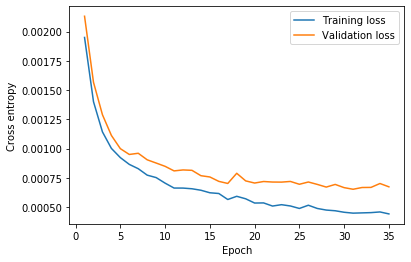

In [13]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [14]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 96.14%


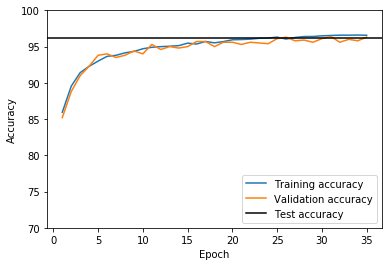

In [15]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.axhline(y=test_acc, c='black', label='Test accuracy')
plt.ylim([70, 100])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Functional API Dropout

In [16]:
import torch.nn.functional as F


class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes, drop_proba, 
                 num_hidden_1, num_hidden_2):
        super(MultilayerPerceptron, self).__init__()
        
        self.drop_proba = drop_proba
        self.linear_1 = torch.nn.Linear(num_features,
                                        num_hidden_1)

        self.linear_2 = torch.nn.Linear(num_hidden_1,
                                        num_hidden_2)
        
        self.linear_out = torch.nn.Linear(num_hidden_2,
                                          num_classes)
        
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = F.dropout(out, p=self.drop_proba, training=self.training)
        out = self.linear_2(out)
        out = F.relu(out)
        out = F.dropout(out, p=self.drop_proba, training=self.training)
        logits = self.linear_out(out)
        probas = F.log_softmax(logits, dim=1)
        return logits, probas

In [17]:
#################################
### Model Initialization
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=DROP_PROBA,
                             num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#################################
### Training
#################################

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28)
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | ' 
                   f'Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/035 | Batch 000/230 | Cost: 2.3072
Epoch: 001/035 | Batch 120/230 | Cost: 0.9767
Epoch: 001/035 Train Acc.: 85.94% | Validation Acc.: 85.20%
Time elapsed: 0.12 min
Epoch: 002/035 | Batch 000/230 | Cost: 0.7529
Epoch: 002/035 | Batch 120/230 | Cost: 0.7045
Epoch: 002/035 Train Acc.: 89.54% | Validation Acc.: 88.80%
Time elapsed: 0.24 min
Epoch: 003/035 | Batch 000/230 | Cost: 0.6117
Epoch: 003/035 | Batch 120/230 | Cost: 0.5544
Epoch: 003/035 Train Acc.: 91.41% | Validation Acc.: 91.00%
Time elapsed: 0.35 min
Epoch: 004/035 | Batch 000/230 | Cost: 0.5756
Epoch: 004/035 | Batch 120/230 | Cost: 0.4749
Epoch: 004/035 Train Acc.: 92.28% | Validation Acc.: 92.30%
Time elapsed: 0.47 min
Epoch: 005/035 | Batch 000/230 | Cost: 0.4690
Epoch: 005/035 | Batch 120/230 | Cost: 0.4591
Epoch: 005/035 Train Acc.: 93.00% | Validation Acc.: 93.80%
Time elapsed: 0.59 min
Epoch: 006/035 | Batch 000/230 | Cost: 0.4363
Epoch: 006/035 | Batch 120/230 | Cost: 0.4432
Epoch: 006/035 Train Acc.: 93.65%

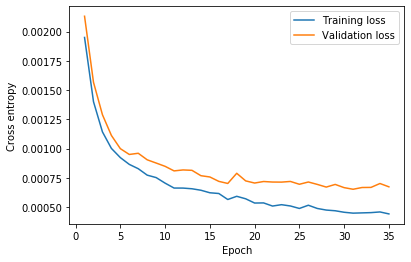

In [18]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [19]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 96.14%


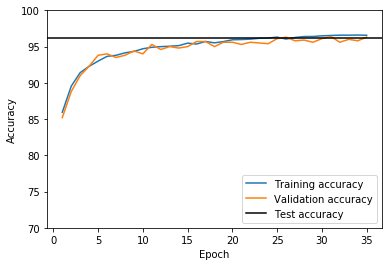

In [20]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.axhline(y=test_acc, c='black', label='Test accuracy')
plt.ylim([70, 100])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()